# Momentum Studies

Study momentum (SMA, EMA, RSI) strategies on ETFs.

- [x] KDE of fast/slow windows
- [x] Add RSI strategies
- [ ] Investigate leverged and inverse (levered) ETFs
- [ ] Cross check with SPY and IWM
- [ ] Moving X years window for MA windows
- [ ] Real backtest with fees and ask prices
- [ ] Deploy with half Kelly

## Fetch data

In [19]:
# Yahoo Finance

import yfinance as yf
import pandas as pd
from datetime import date
import os
from glob import glob

now = date.today().isoformat()

assets = [
    # QQQ
    'QQQ',
    'QLD', # 2x long
    'TQQQ', # 3x long
    'PSQ', # 1x short
    'QID', # 2x short
    'SQQQ', # 3x short

    # IWM
    'IWM',
    'UWM', # 2x long
    'TNA', # 3x long
    'RWM', # 1x short
    'TWM', # 2x short
    'TZA', # 3x short

    # SPX
    'SPY',
    'SSO', # 2x long
    'UPRO', # 3x long
    'SH', # 1x short
    'SDS', # 2x short
    'SPXU', # 3x short
]

for s in assets:
    if len(glob(f'fundamental/{s.lower()}-????-??-??.parquet')) > 0:
        print(f'skipping {s.lower()}')
        continue

    df = yf.download(s, period='max',interval='1d',multi_level_index=False,auto_adjust=True)

    df.reset_index(inplace=True)
    df.rename(columns={
        'Open':'open',
        'High':'high',
        'Low':'low',
        'Close':'close',
        'Volume':'volume',
        'Date':'timestamp'},inplace=True)
    
    # index by date
    df.timestamp = pd.to_datetime(df.timestamp)
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    p = os.path.join('fundamental',f'{s.lower()}-{now}.parquet')
    df.to_parquet(p, engine='pyarrow', compression='zstd')
    

skipping qqq
skipping qld
skipping tqqq
skipping psq
skipping qid
skipping sqqq
skipping iwm
skipping uwm
skipping tna
skipping rwm
skipping twm
skipping tza
skipping spy
skipping sso
skipping upro
skipping sh
skipping sds
skipping spxu


In [3]:
import functools as fc
import itertools as it
import pandas as pd
import numpy as np
import warnings
import os

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

src = "fundamental/qqq-2025-11-14.parquet"
dst = "derived/qqq-2025-11-14-mom-signals.parquet"

df = pd.read_parquet(src)
df['absret'] = df.open - df.shift(1).open

windows = list(range(1,30)) + list(range(30,100,5)) + list(range(100,500,10))

# compute sma
for w in windows:
    sma = df.open.rolling(w, min_periods=1).mean()    
    df[f'sma{w}'] = sma.where(sma.notna(), df.open)

# compute ema
for w in windows:
    ema = df.open.ewm(span=w, adjust=False).mean()    
    df[f'ema{w}'] = ema.where(ema.notna(), df.open)

df = df.copy()

# compute rsi
for w in windows:
    up = df.absret.where(df.absret > 0.0, 0).ewm(com=w - 1,adjust=False,min_periods=w).mean()
    down = df.absret.where(df.absret < 0.0, 0).ewm(com=w - 1,adjust=False,min_periods=w).mean()
    rsi = 100 - (100 / (1 + (up / (-1 * down))))
    
    edge = lambda a,b: 1 if a < 50 and b > 50 else -1 if a > 70 and b < 70 else 0
    df[f'rsi{w}'] = rsi.rolling(2,min_periods=2).apply(lambda r: edge(r.iloc[0], r.iloc[1])) \
                       .replace(0.0,np.nan).ffill()

# open and sma/ema
for w in windows:
    df[f'open_sma{w}'] = df.open - df[f'sma{w}']
    df[f'open_ema{w}'] = df.open - df[f'ema{w}']

# fast and slow sma/ema
for [fast, slow] in filter(lambda w: w[0] < w[1], it.product(windows, windows)):
    df[f'sma{fast}_{slow}'] = df[f'sma{fast}'] - df[f'sma{slow}']
    df[f'ema{fast}_{slow}'] = df[f'ema{fast}'] - df[f'ema{slow}']
    df[f'emasma{fast}_{slow}'] = df[f'ema{fast}'] - df[f'sma{slow}']

df.to_parquet(dst, engine='pyarrow', compression='zstd')

In [4]:
# signal returns

import functools as fc
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

df = pd.read_parquet(os.path.join('derived','qqq-2025-11-14-mom-signals.parquet'))

signals = list(filter(lambda c: re.match(r'^(open_.+)|(.ma\d+_.+)|(rsi.+)|(emasma.+)$', c), df.columns.values))

eodret = np.log(df.open / df.shift(1).open).shift(-1)

res = pd.DataFrame(np.nan, index=signals, columns=('ret','sd','avg'))
res.loc['benchmark'] = [eodret.sum(), eodret.std(), eodret.mean()]

for s in signals:
    perf = eodret.where(df[s] > 0, 0)
    res.loc[s] = [perf.sum(), perf.std(), perf.mean()]

res['ir'] = np.nan_to_num((res.avg - res.loc['benchmark'].avg) / res.sd)
res.sort_values(['ir'],inplace=True, ascending=False)

# best strategies
res.iloc[-200:]

,ret,sd,avg,ir
sma6_9,0.950897,0.011182,0.000142,-2.275803e-02
emasma3_12,1.033786,0.010610,0.000154,-2.282092e-02
emasma6_11,1.023586,0.010660,0.000152,-2.285726e-02
emasma22_25,0.996936,0.010793,0.000149,-2.294005e-02
emasma3_11,1.012012,0.010645,0.000151,-2.304965e-02
...,...,...,...,...
open_sma2,-0.897748,0.011316,-0.000134,-4.682145e-02
emasma1_2,-0.897748,0.011316,-0.000134,-4.682145e-02
sma1_2,-0.897748,0.011316,-0.000134,-4.682145e-02
open_sma1,0.000000,0.000000,0.000000,-1.797693e+308


/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)
/Users/kai/studies/.venv/lib/python3.13/site-packages/matplotlib/colors.py:2295: RuntimeWarning: overflow encountered in divide
  resdat /= (vmax - vmin)


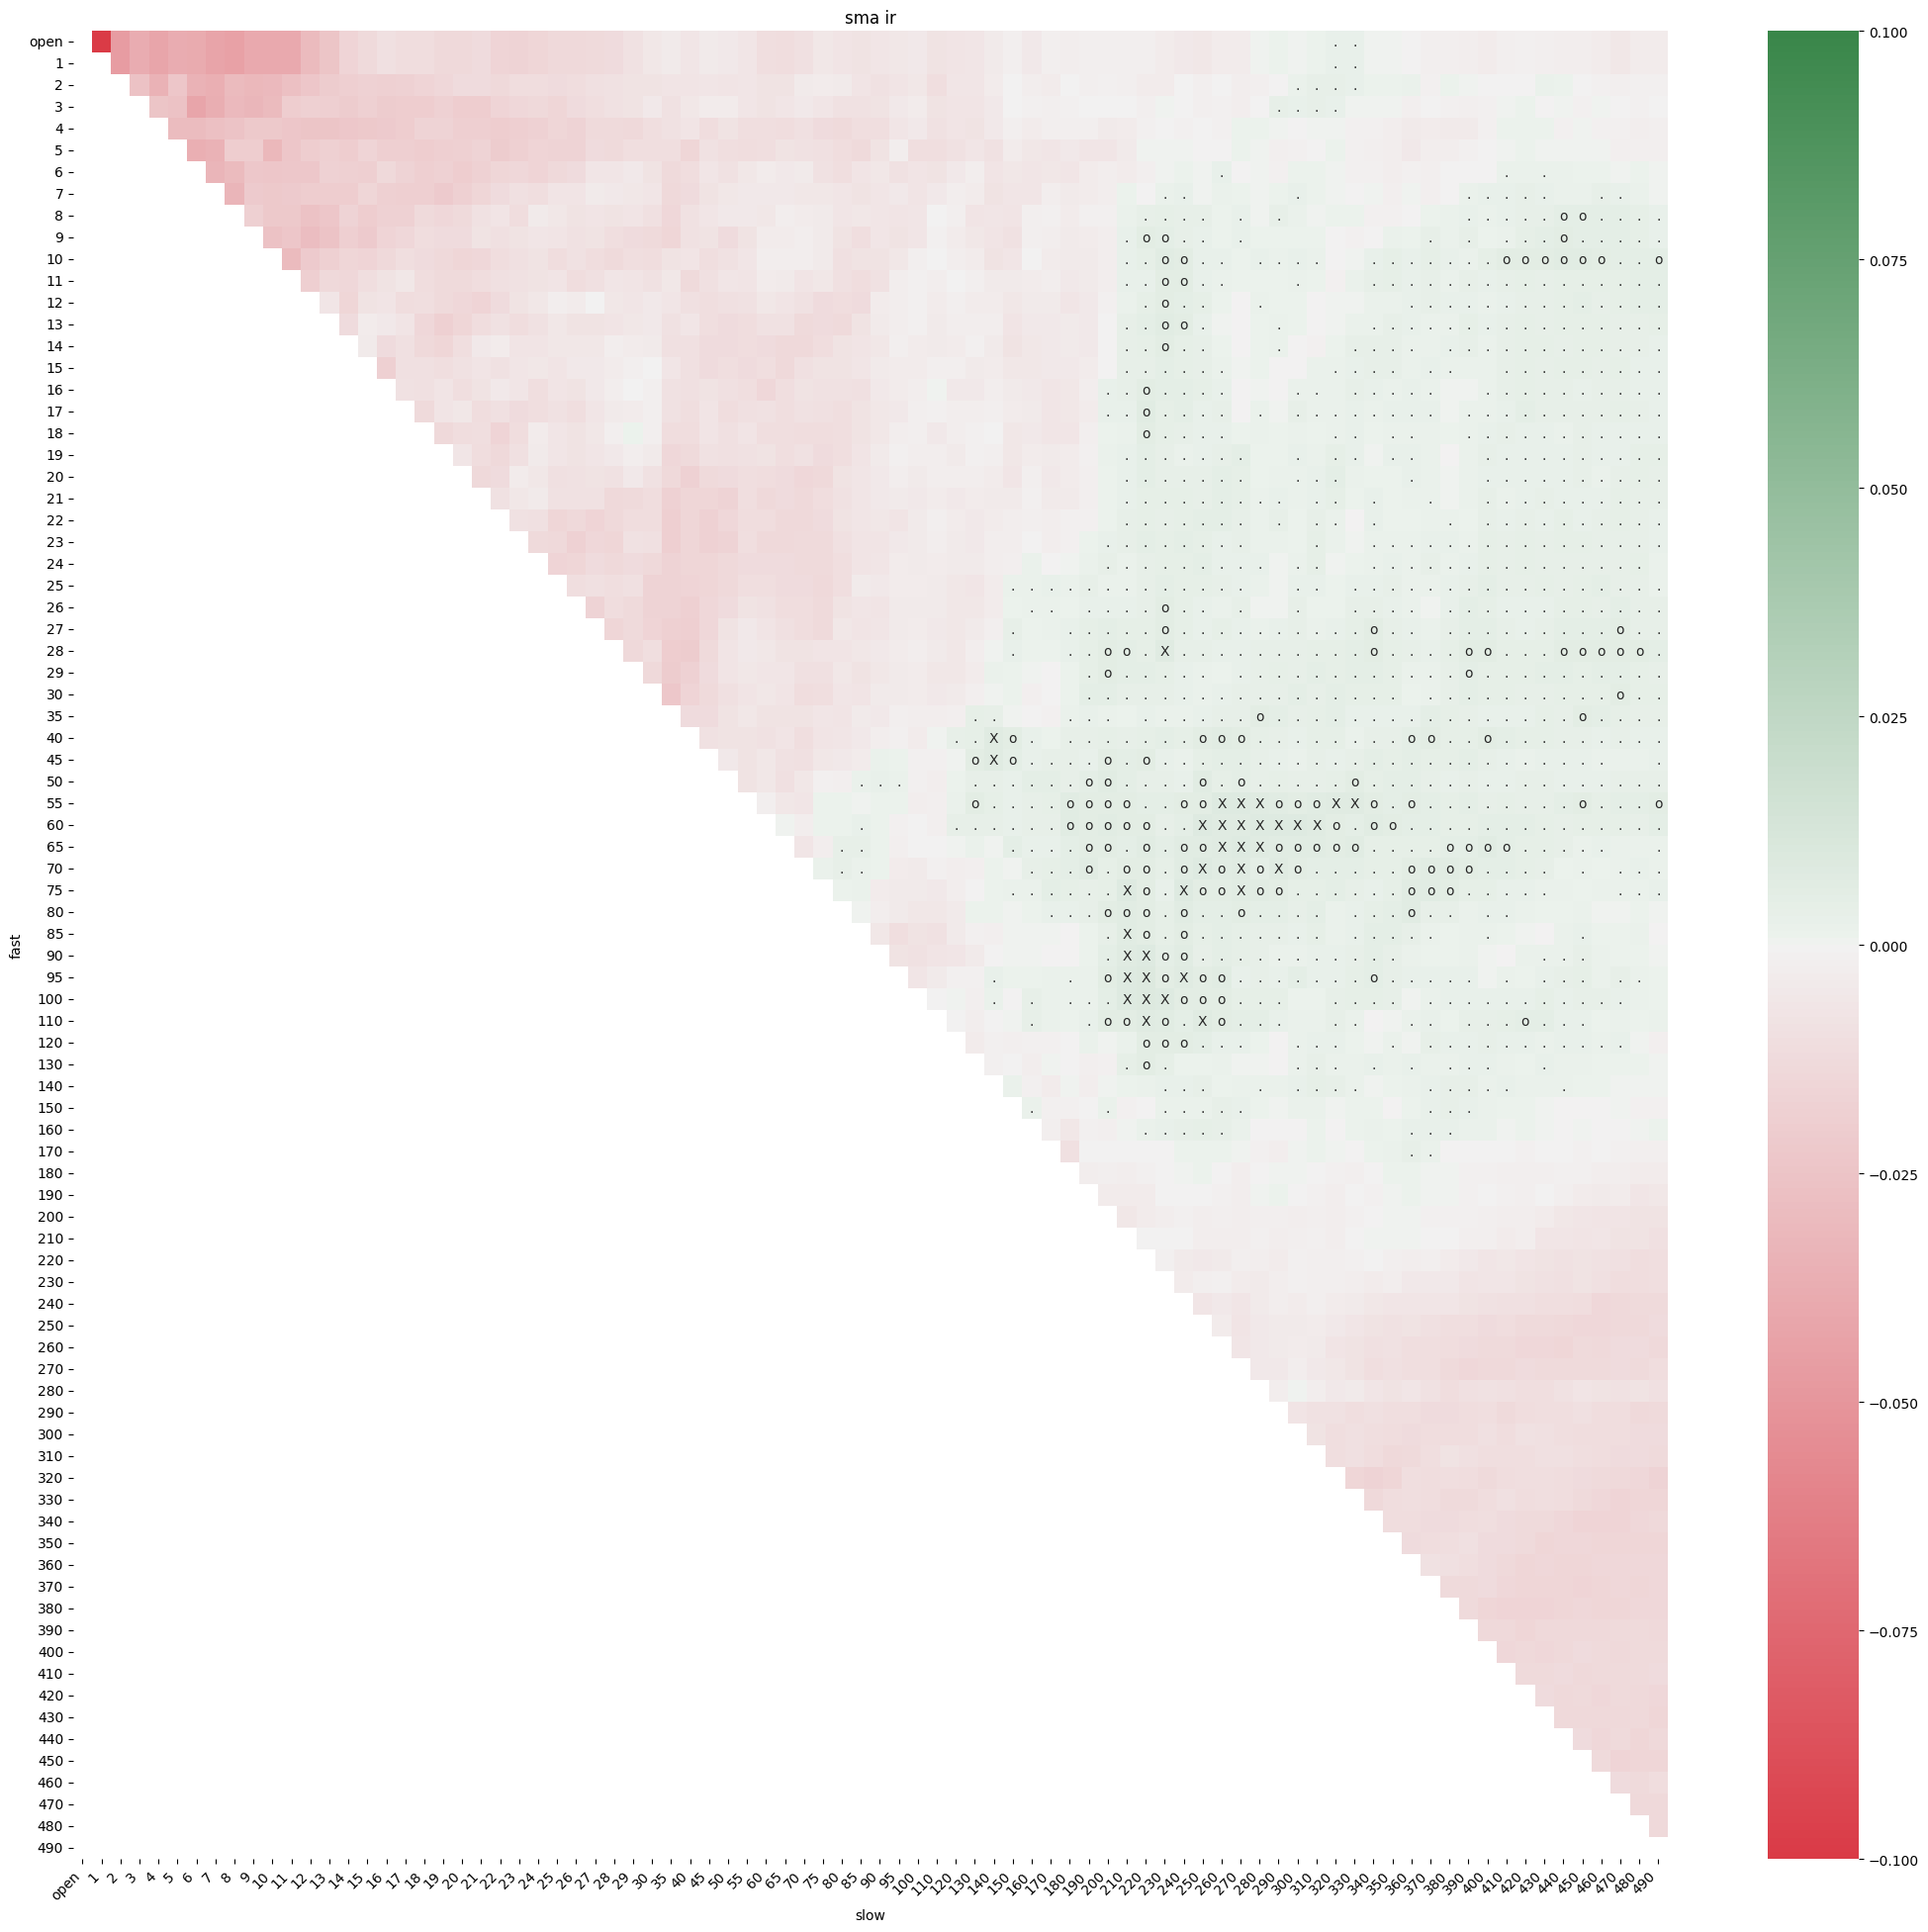

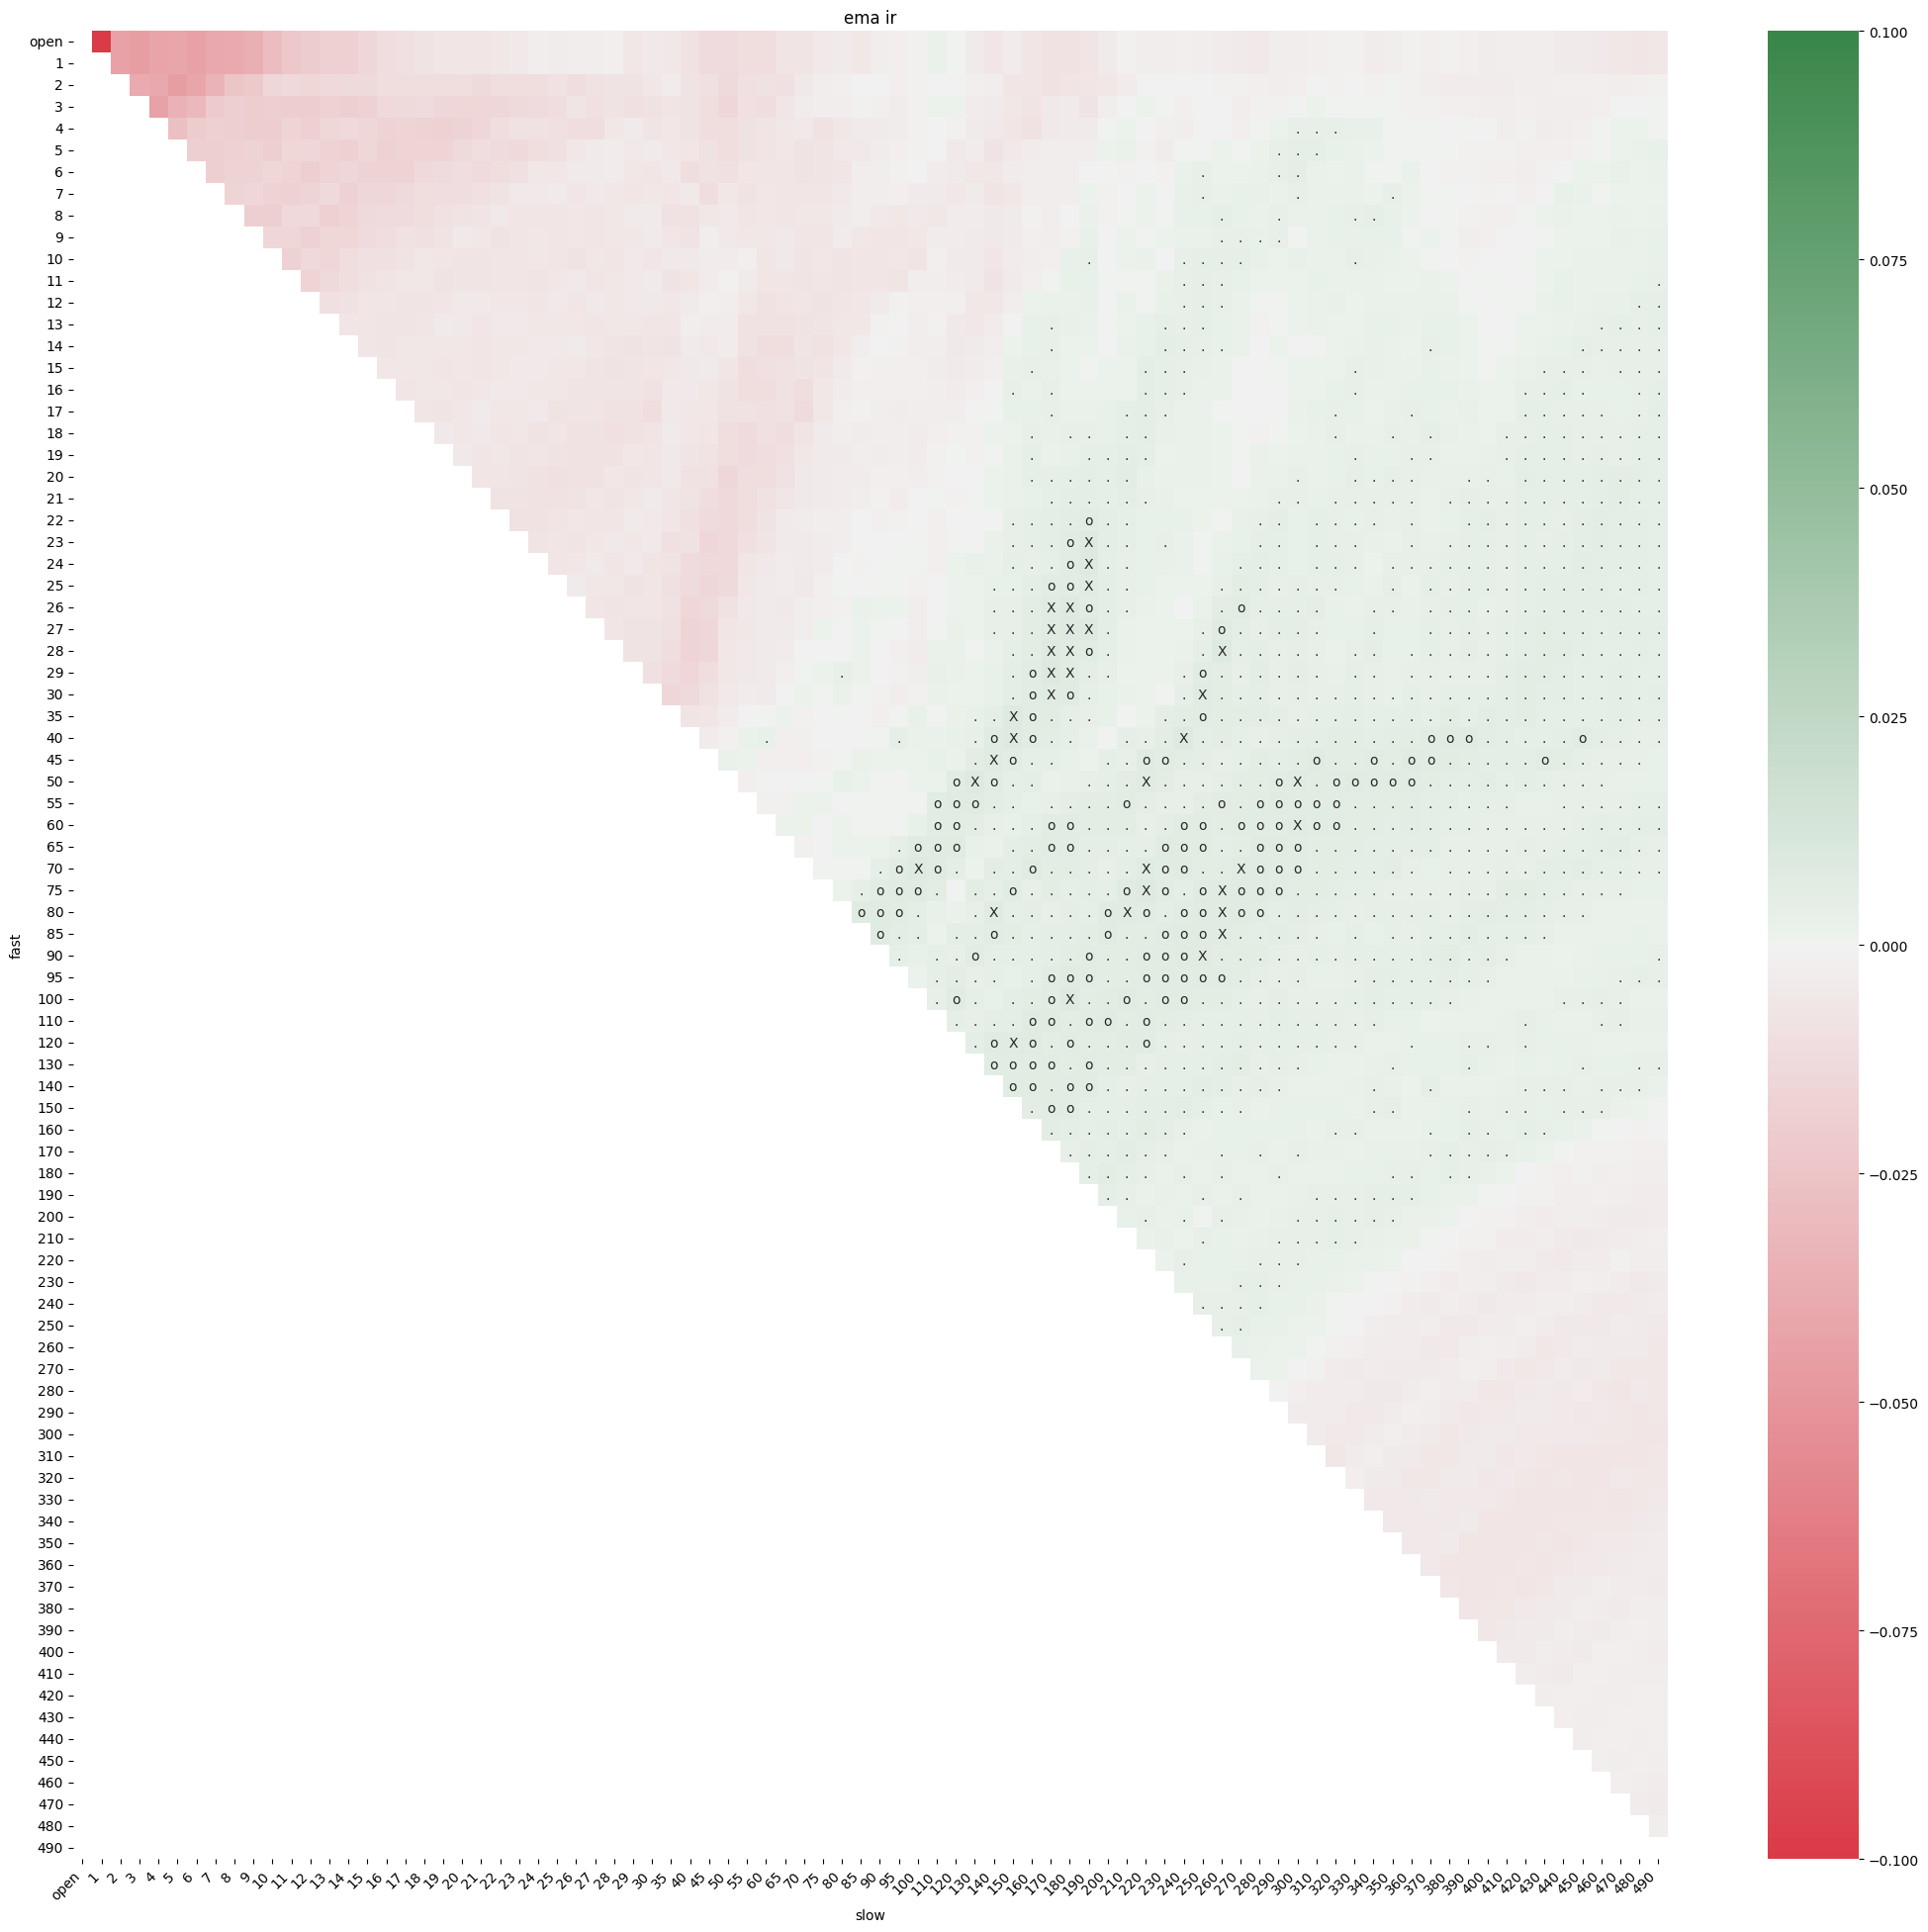

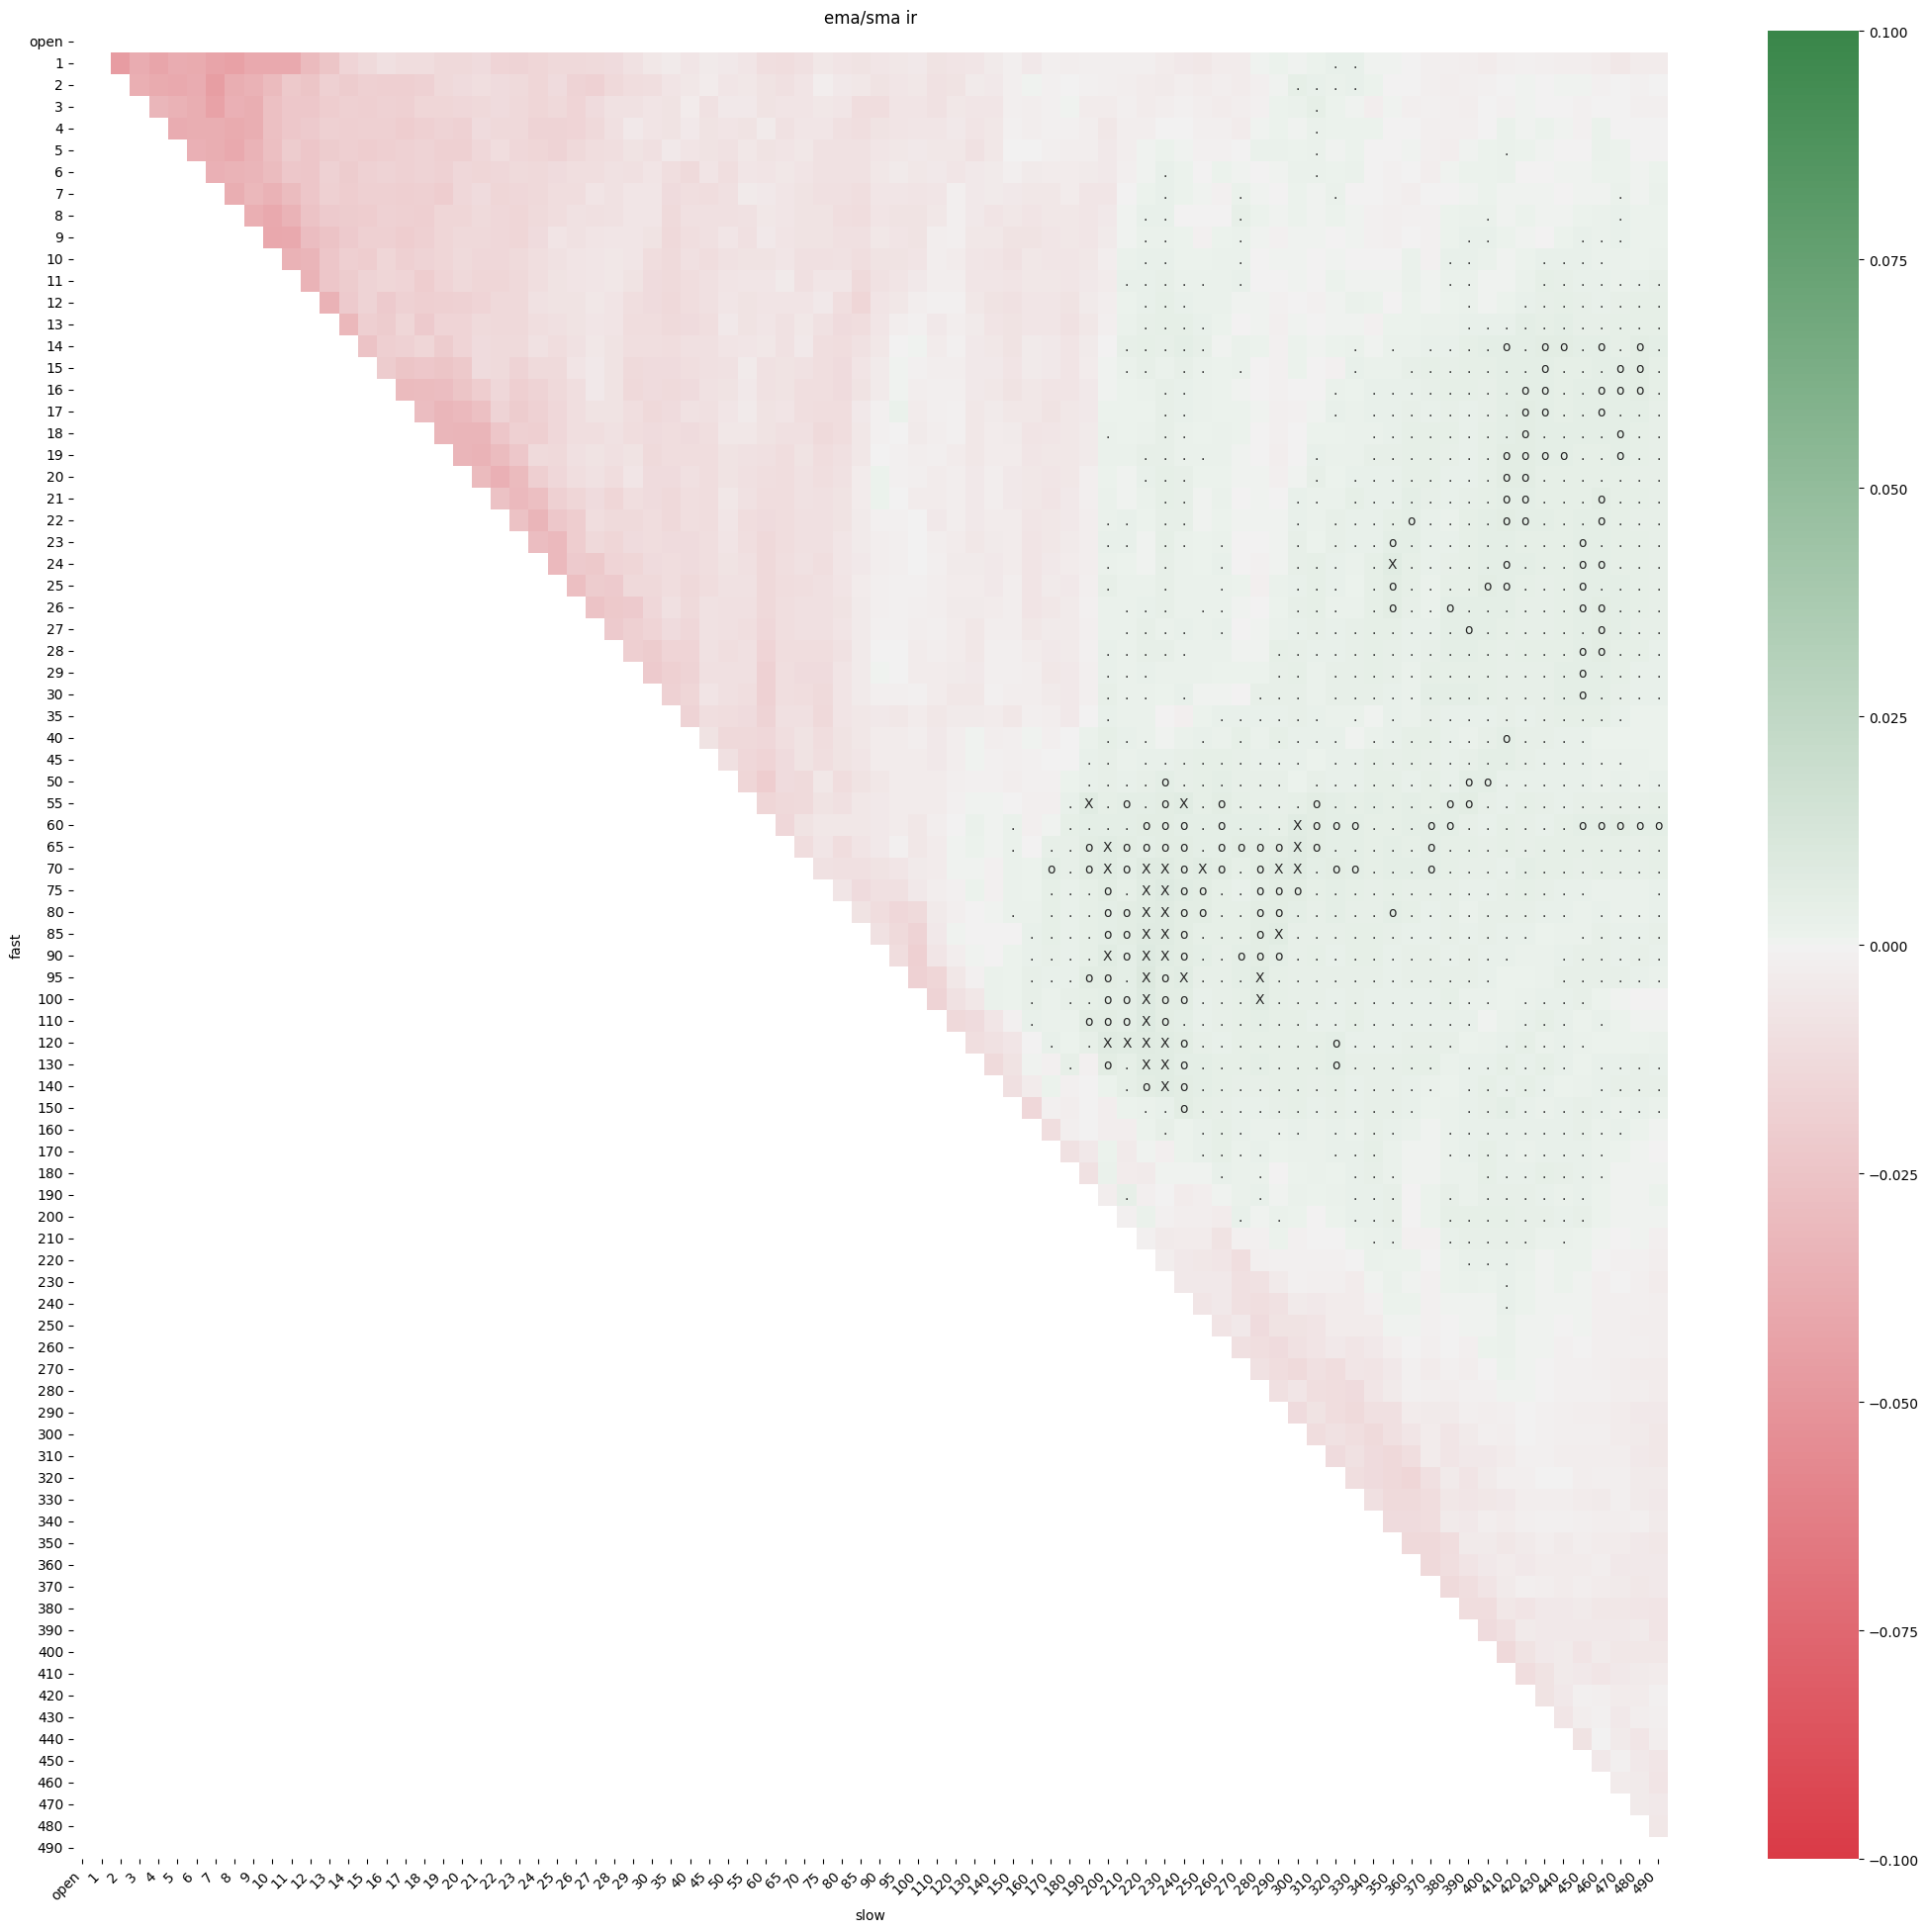

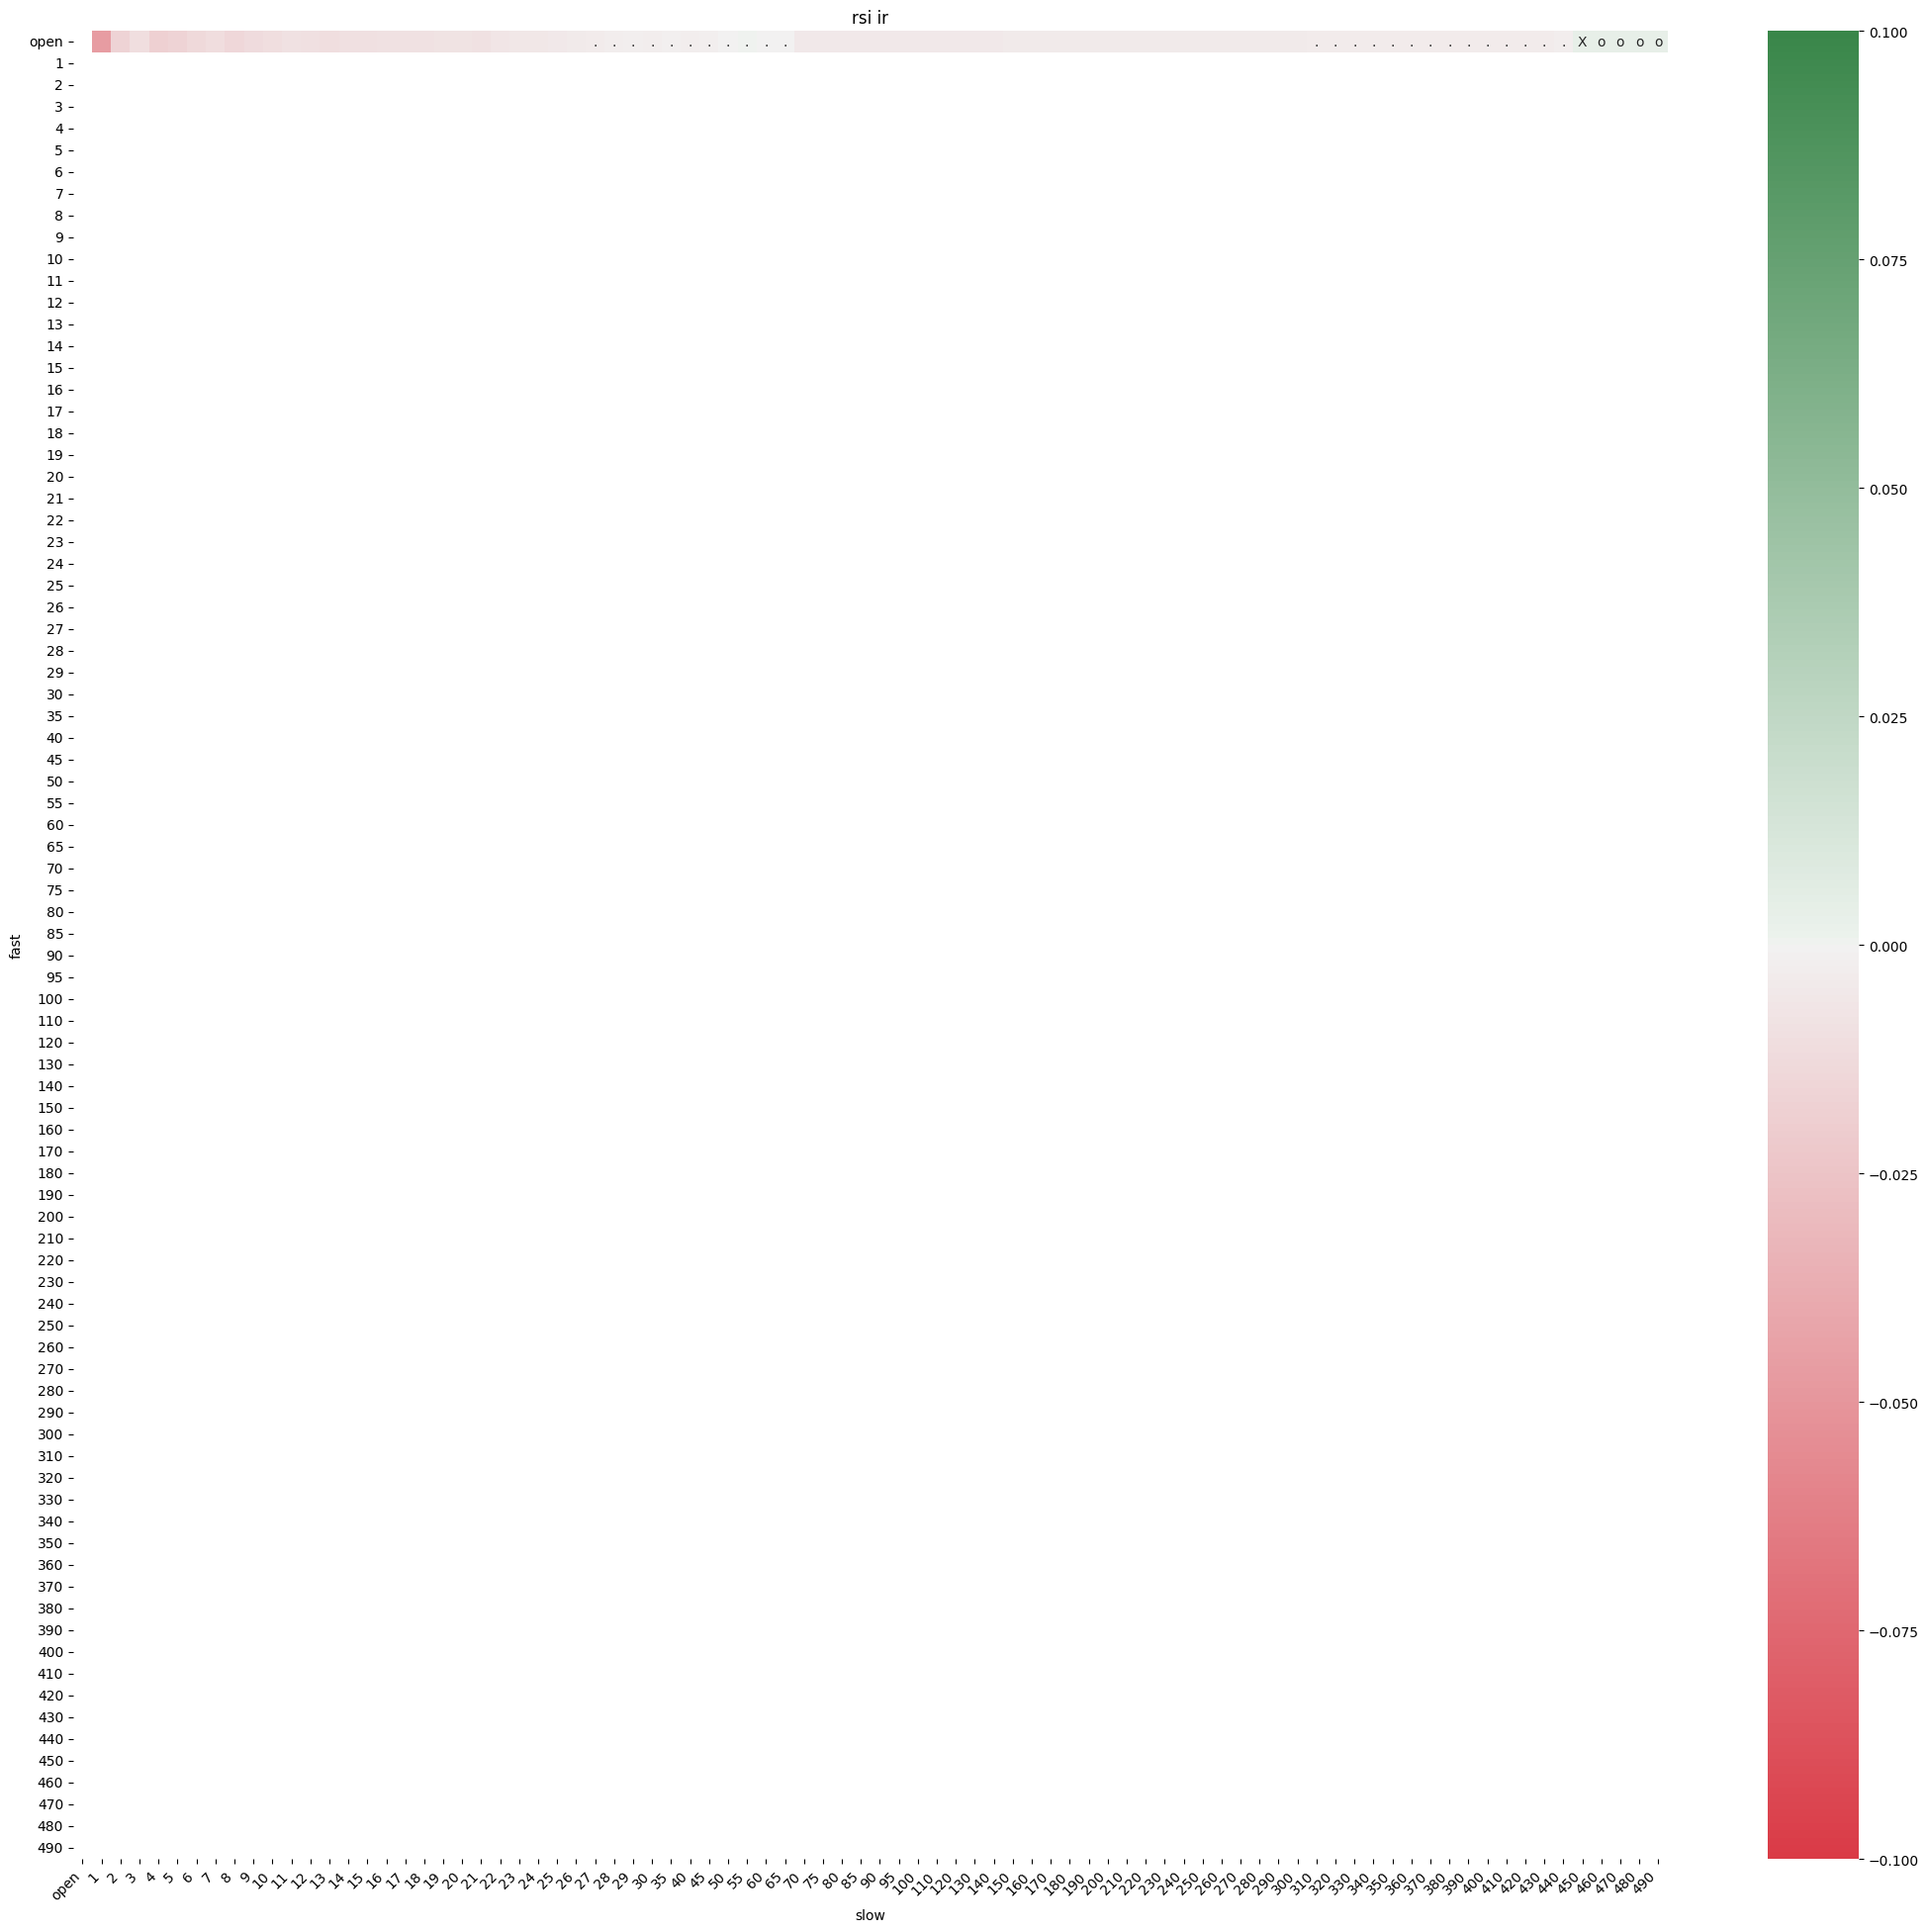

In [26]:
# heatmaps

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle

windows = list(range(1,30)) + list(range(30,100,5)) + list(range(100,500,10))


# fast / slow
sma_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
ema_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
rsi_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)
mix_ir = np.full((len(windows) + 1, len(windows) + 1), np.nan)

ew = list(enumerate(windows,start=1))
for [i,w] in ew:
    sma_ir[0,i] = res.loc[f'open_sma{w}'].ir
    ema_ir[0,i] = res.loc[f'open_ema{w}'].ir
    rsi_ir[0,i] = res.loc[f'rsi{w}'].ir
    
for [[i,fast], [j,slow]] in filter(lambda w: w[0][1] < w[1][1], it.product(ew,ew)):
    sma_ir[i,j] = res.loc[f'sma{fast}_{slow}'].ir
    ema_ir[i,j] = res.loc[f'ema{fast}_{slow}'].ir
    mix_ir[i,j] = res.loc[f'emasma{fast}_{slow}'].ir

cm = sns.diverging_palette(h_neg=10, h_pos=133, s=75, l=50, as_cmap=True)

for [nam, arr] in [['sma',sma_ir],['ema',ema_ir],['ema/sma',mix_ir],['rsi',rsi_ir]]:
    fig = plt.figure(figsize=(26,24))
    ax = fig.add_subplot(111)

    [p68,p95,p99] = np.nanpercentile(arr, [68,95,99])

    sns.heatmap(
        arr,
        ax=ax,
        mask=np.isnan(arr),
        vmin=np.min(arr),
        vmax=np.max(arr),
        annot=np.where(arr >= p99, 'X', np.where(arr >= p95, 'o', np.where(arr >= p68, '.', ''))),
        fmt='s',
        cmap=cm)
    
    ax.set_yticklabels(['open'] + windows, rotation=0)
    ax.set_xticklabels(['open'] + windows, rotation=45, ha='right')
    ax.set(ylabel="fast", xlabel="slow")
    ax.set_title(f'{nam} ir')
        
    
plt.show()

In [ ]:
lookfwd = 60 # trading days
runs = []
active = None
for date in df.index:
    go_long = df.long_signal[date]
    go_short = df.short_signal[date]
    
    if active == None:
        if go_long:
            active = date
        continue
    if not go_short and len(df.open[active:date]) <= lookfwd:
        continue

    entry = df.open[active]
    run = df.open[active:date].apply(lambda x: x/entry).values[1:]
    runs.append(np.pad(run, (0,lookfwd-len(run)), mode='constant',constant_values=np.nan))
    active = None


signal = pd.DataFrame(
    {
        'std': np.nanstd(runs,axis=0),
        'mean': np.nanmean(runs,axis=0),
        'min': np.nanmin(runs,axis=0),
        'max': np.nanmax(runs,axis=0),
    } + np.quartile(runs,[.25,.5,.75],axis=0
    columns=['std','mean','min','max'],
    index=range(lookfwd))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

open_segs = np.column_stack((range(len(df.open)), np.log(df.open)))
open_segs = list(zip(open_segs, open_segs[1:]))
color_segs = np.where(df.above_sma, 'green', 'red')

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, [ax0, ax1] = plt.subplots(nrows=2,figsize=(1500*px, 1000*px))

# price
ax0.set_xlim(0, len(df.open))
ax0.set_ylim(0, np.log(df.open.max()))
ax0.scatter(range(len(df.index)), np.log(df.open.mask(~df.long_signal)), color='black', s=20)
ax0.add_collection(LineCollection(open_segs,colors=color_segs))
ax0.plot(range(len(df.sma)), np.log(df.sma))

# signal returns
ax1.set_xlim(1, lookfwd)
maxabs = max(abs(1-signal['min'].min()), abs(1-signal['max'].max()))
ax1.set_ylim(1-maxabs, 1+maxabs)

ax1.plot(range(1, lookfwd+1), np.ones(lookfwd), color='red')
# 1 sigma error bars
ax1.errorbar(range(1, lookfwd+1), signal['mean'], yerr=signal['std']*2)
plt.show()

In [36]:
from lightweight_charts import JupyterChart



chart = JupyterChart(toolbox=True) 
chart.set(df[['open','high','low','close','volume']])


chart.horizontal_line(0)
for col in ['sma20']:
    line = chart.create_line(col)
    line.set(df[[col]])
chart.load()
#res.head()
